In [9]:
import pandas as pd
from backend.src.utils.logging_handler import setup_logging
from backend.src.utils.config import Config

config = Config("../config.yaml")
setup_logging()

feature_engineering_config = config.get("feature_engineering")
preprocessor_config = config.get("preprocess")
model_config = config.get("model")

target_feature = preprocessor_config.get("target")
trend_length = preprocessor_config.get("trend_length")
window_size = preprocessor_config.get("window_size")
epochs: int = model_config.get("epochs")
batch_size: int = model_config.get("batch_size")

interval: str = feature_engineering_config.get("time_series_interval")

test_file_path: str = f"../data/twelvedata/time series ({interval})/AMZN/AMZN_time_series.csv"

test_df: pd.DataFrame = pd.read_csv(test_file_path)

,datetime,open,high,low,close,volume
0,2023-02-22 10:30:00,95.69,96.98,95.65,96.22,8365097
1,2023-02-22 11:30:00,96.22,96.55,95.71,96.03,4727154
2,2023-02-22 12:30:00,96.03,96.30,95.88,96.14,3013457
3,2023-02-22 13:30:00,96.16,96.31,95.25,95.53,5525224
4,2023-02-22 14:30:00,95.54,95.89,95.12,95.52,6051030
...,...,...,...,...,...,...
4995,2025-12-30 11:30:00,231.85,231.97,231.10,231.29,1194488
4996,2025-12-30 12:30:00,231.28,231.46,231.06,231.20,1106057
4997,2025-12-30 13:30:00,231.18,231.86,231.08,231.70,1537866
4998,2025-12-30 14:30:00,231.70,231.80,231.23,231.74,1443287


In [10]:
from keras.models import load_model
from backend.src.evaluation.model_evaluator import ModelEvaluator
from backend.src.pipelines.stock_trend_lstm_test_pipeline import StockTrendLSTMTestPipeline

model_path: str = "../src/models/saved models/trained_StockTrendLSTM_model.keras"
model = load_model(model_path)

scaler_path: str = "C:/Users/mohae/Desktop/StockTrendPredictor/backend/src/models/saved scalers/scaler.save"

test_pipeline = StockTrendLSTMTestPipeline(
    testing_time_series=test_df,
    target_feature=target_feature,
    trend_length=trend_length,
    window_size=window_size,
    scaler_path=scaler_path,
)
test_pipeline.prepare_data()
X_test, y_test = test_pipeline.get_test_data()

y_val_proba = model.predict(X_test).ravel()

evaluator = ModelEvaluator(
    y_true=y_test,
    y_proba=y_val_proba,
)

2025-12-31 02:21:56,337 | INFO | backend.src.pipelines.stock_trend_lstm_test_pipeline | StockTrendLSTMTestPipeline initialized
2025-12-31 02:21:56,337 | INFO | backend.src.pipelines.stock_trend_lstm_test_pipeline | Starting data preparation
2025-12-31 02:21:56,353 | INFO | backend.src.preprocessing.time_series_preprocessor | Preprocessing summary | input rows: 5000 | output rows: 5000 | dropped: 0 (100.00% retained)
2025-12-31 02:21:56,516 | INFO | backend.src.pipelines.stock_trend_lstm_test_pipeline | Test data preparation completed


154/154 [==============================] - 2s 7ms/step


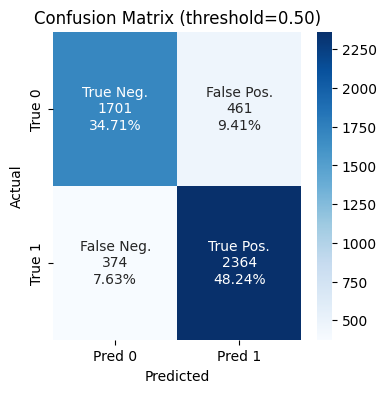

In [11]:
evaluator.plot_confusion_matrix(threshold=0.5)


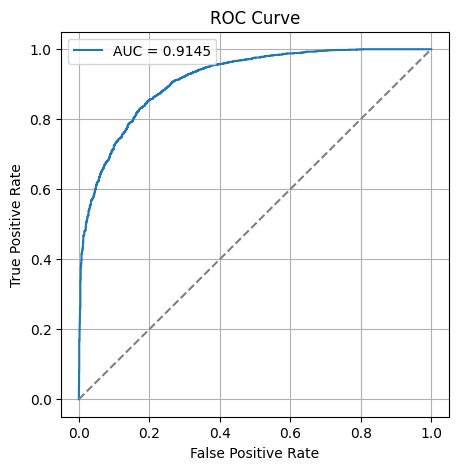

In [12]:
evaluator.plot_roc_curve()


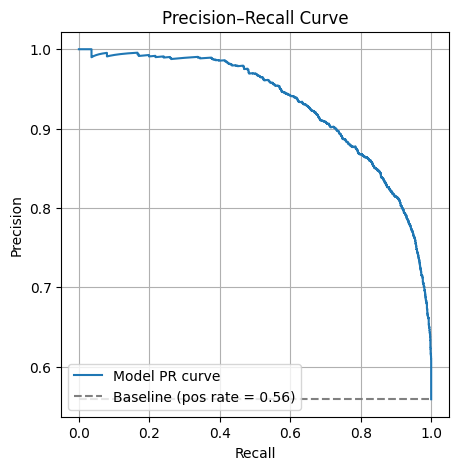

In [13]:
evaluator.plot_precision_recall_curve()


In [14]:
sweep_df = evaluator.threshold_sweep()
best_f1 = sweep_df.loc[sweep_df["f1"].idxmax()]
best_f1

threshold    0.410000
accuracy     0.830612
precision    0.812377
recall       0.906136
f1           0.856699
Name: 40, dtype: float64

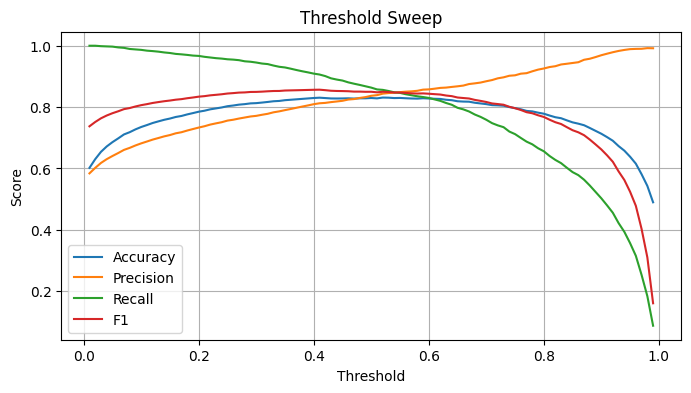

In [15]:
evaluator.plot_threshold_sweep()



Predicted probability quantiles:
  group    p10    p50    p90
overall 0.0318 0.6737 0.9807
class_0 0.0104 0.1548 0.7380
class_1 0.4209 0.9012 0.9889


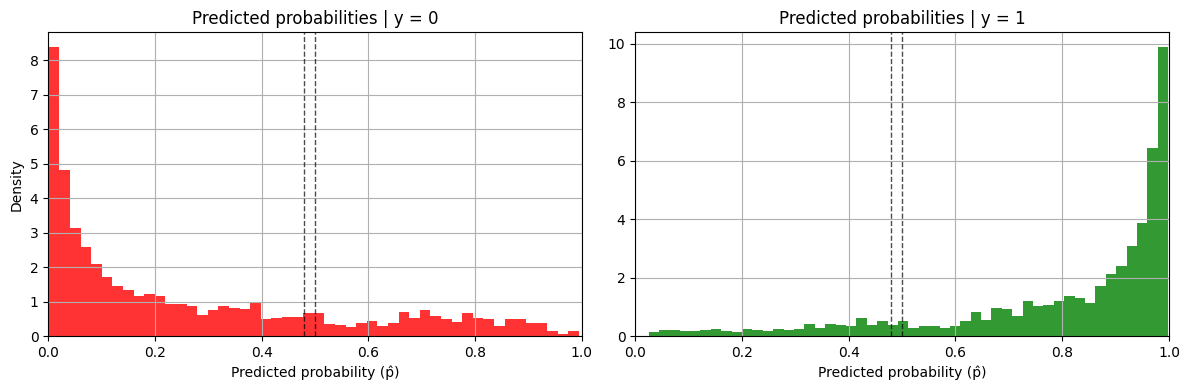

In [16]:
evaluator.summary_probability_stats()
evaluator.plot_probability_distribution(show_thresholds=[0.5, 0.48])